In [41]:
%load_ext autoreload
%autoreload 2

In [49]:
# %pip install -q matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip uninstall --yes diffusers
# %pip install git+https://github.com/neverix/diffusers@patch-4

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/neverix/diffusers (to revision patch-4) to /tmp/pip-req-build-9kax1u0n
  Running command git clone -q https://github.com/neverix/diffusers /tmp/pip-req-build-9kax1u0n
  Running command git checkout -b patch-4 --track origin/patch-4
  Switched to a new branch 'patch-4'
  Branch 'patch-4' set up to track remote branch 'patch-4' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 14.1 MB/s eta 0:00:01
     |████████████████████████████████| 330 kB 109.4 MB/s eta 0:00:01
     |████████████████████████████████| 777 kB 93.9 MB/s eta 0:00:01
     |████████████████████████████████| 168 kB 110.2 MB/s eta 0:00:01
  Using cached packaging-23.2-py3-none-any.whl (53 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Created wheel for diffusers: filename=diffusers-0

In [3]:
# !rm -rf ~/.cache/huggingface/hub
# !rm -rf cache

In [4]:
# !mkdir -p cache
# !cd cache && GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0 --depth=1
# !cd cache/stable-diffusion-xl-base-1.0 && git lfs pull --include '*.msgpack' && git lfs pull --include '*.model' && git lfs pull --include '*.json'

In [1]:
from diffusers import FlaxStableDiffusionXLPipeline
import jax.numpy as jnp


dtype = jnp.bfloat16
pipe, params = FlaxStableDiffusionXLPipeline.from_pretrained(
    # "nev/
    # lcm-sdxl-flax",
    # "nev/lcm-sdxl-pt",
    # "nev/sdxl-turbo-pt",
    # "stabilityai/stable-diffusion-xl-base-1.0",
    # "cache/stable-diffusion-xl-base-1.0",
    # "pcuenq/stable-diffusion-xl-base-1.0-flax",
    # "stabilityai/sdxl-turbo",
    from_pt=True,
    dtype=jnp.float32
)

/home/neverix/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 94371.84it/s]


In [3]:
import jax
print(jax.devices())

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [15]:
from diffusers import FlaxEulerDiscreteScheduler, FlaxAutoencoderKL
_, scheduler_state = FlaxEulerDiscreteScheduler.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    subfolder="scheduler"  # mad at them for not calling it scheuler
)
_, vae_state = FlaxAutoencoderKL.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    subfolder="vae"
)

vae/config.json: 100%|██████████| 642/642 [00:00<00:00, 2.74MB/s]
diffusion_flax_model.msgpack: 100%|██████████| 335M/335M [00:02<00:00, 149MB/s] 


In [16]:
# scheduler_state = params.pop("scheduler")
# vae_state = params.pop("vae")
params = jax.tree_util.tree_map(lambda x: x.astype(dtype), params)
params["scheduler"] = scheduler_state
params["vae"] = vae_state

In [17]:
from flax.training.common_utils import shard
from flax.jax_utils import replicate
import numpy as np


p_params = replicate(params)

def create_key(seed=0):
    return jax.random.PRNGKey(seed)

rng = create_key(0)
rng = jax.random.split(rng, jax.device_count())

do_jit = True

# def generate(prompt_ids, neg_prompt_ids):
#     images = pipe(
#         prompt_ids if do_jit else prompt_ids[0],
#         p_params if do_jit else params,
#         rng if do_jit else rng[0],
#         num_inference_steps=1,
#         # neg_prompt_ids=neg_prompt_ids if do_jit else neg_prompt_ids[0],
#         guidance_scale = 1.0,
#         jit=do_jit,
#     ).images
#     images = images.reshape((images.shape[0] * images.shape[1], ) + images.shape[-3:])
#     return pipe.numpy_to_pil(np.array(images))

In [18]:
imgs_per_device = 1

prompt = "a cat"
prompts = [prompt] * jax.device_count() * imgs_per_device
prompt_ids = pipe.prepare_inputs(prompts)
prompt_ids = shard(prompt_ids)

# neg_prompt = "misshapen"
# neg_prompts = [neg_prompt] * jax.device_count() * imgs_per_device
# neg_prompt_ids = pipe.prepare_inputs(neg_prompts)
# neg_prompt_ids = shard(neg_prompt_ids)

# for u in generate(prompt_ids, neg_prompt_ids):
#     display(u)

In [19]:
prompt_embeds, pooled_embeds = jax.pmap(pipe.get_embeddings)(prompt_ids, p_params)

In [33]:
height, width = 512, 512
add_time_ids = pipe._get_add_time_ids(
    (height, width), (0, 0), (height, width), 1, dtype=prompt_embeds.dtype
)

In [35]:
batch_size = prompt_embeds.shape[0]
latents_shape = (
    1,  # batch_size,
    pipe.unet.config.in_channels,
    height // pipe.vae_scale_factor,
    width // pipe.vae_scale_factor,
)
latents = jax.pmap(lambda x: jax.random.normal(x, shape=latents_shape, dtype=jnp.float32))(rng)

In [47]:
added_cond_kwargs = {"text_embeds": pooled_embeds, "time_ids": replicate(add_time_ids)}
noise_pred = jax.pmap(pipe.unet.apply)(
    {"params": p_params["unet"]},
    jnp.array(latents),
    replicate(jnp.array([pipe.scheduler.config.num_train_timesteps - 1], dtype=jnp.int32)),
    prompt_embeds,
    added_cond_kwargs,
).sample

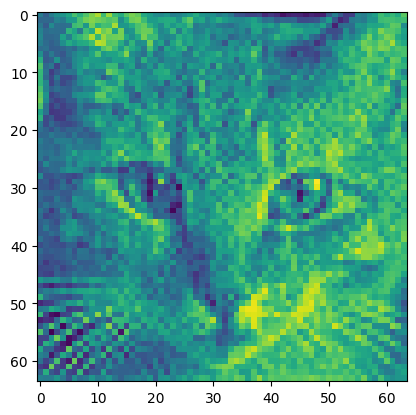

In [102]:
from matplotlib import pyplot as plt
denoised = latents - noise_pred
plt.imshow(denoised[0, 0, 0])
plt.show()

In [66]:
p_vae_state = replicate(vae_state)

In [103]:
from flax import linen as nn

def decode(self, *args, **kwargs):
    return self.decode(*args, **kwargs)

decoded = jax.pmap(nn.apply(decode, pipe.vae))(
    {"params": p_vae_state}, denoised * scheduler_state.init_noise_sigma / pipe.vae.scaling_factor).sample

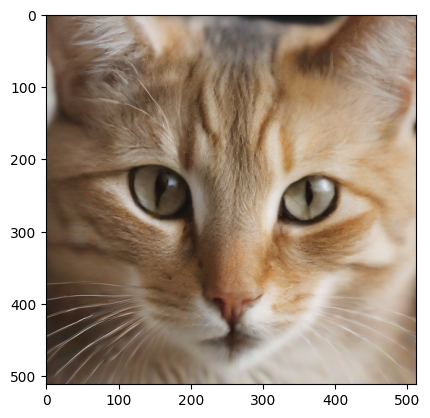

In [104]:
plt.imshow(decoded[0, 0].transpose(1, 2, 0) / 2 + 0.5)
plt.show()